In [ ]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
#data preprocessing
input_file = open('goblet_book.txt', 'r')
input_data = input_file.read()
char_list = []
for char in list(input_data):
    char_list.append(char)

book_chars = np.unique(char_list)
K = len(book_chars)

char_to_ind = {}
for index, book_char in enumerate(book_chars):
    char_to_ind[book_char] = index

ind_to_char = {}
for index, book_char in enumerate(book_chars):
    ind_to_char[index] = book_char

print(ind_to_char)
print(char_to_ind)
print(K)


{0: '\t', 1: '\n', 2: ' ', 3: '!', 4: '"', 5: "'", 6: '(', 7: ')', 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '6', 18: '7', 19: '9', 20: ':', 21: ';', 22: '?', 23: 'A', 24: 'B', 25: 'C', 26: 'D', 27: 'E', 28: 'F', 29: 'G', 30: 'H', 31: 'I', 32: 'J', 33: 'K', 34: 'L', 35: 'M', 36: 'N', 37: 'O', 38: 'P', 39: 'Q', 40: 'R', 41: 'S', 42: 'T', 43: 'U', 44: 'V', 45: 'W', 46: 'X', 47: 'Y', 48: 'Z', 49: '^', 50: '_', 51: 'a', 52: 'b', 53: 'c', 54: 'd', 55: 'e', 56: 'f', 57: 'g', 58: 'h', 59: 'i', 60: 'j', 61: 'k', 62: 'l', 63: 'm', 64: 'n', 65: 'o', 66: 'p', 67: 'q', 68: 'r', 69: 's', 70: 't', 71: 'u', 72: 'v', 73: 'w', 74: 'x', 75: 'y', 76: 'z', 77: '}', 78: 'ü', 79: '•'}
{'\t': 0, '\n': 1, ' ': 2, '!': 3, '"': 4, "'": 5, '(': 6, ')': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '6': 17, '7': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 3

In [ ]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis = 0)

class RNN:
    def __init__(self, b, c, u, w, v):
        self.b = b
        self.c = c
        self.U = u
        self.W = w
        self.V = v

    def synthesize_text(self, ix, h, n):
        xnext = np.zeros((K, 1))
        xnext[ix] = 1

        synthesized_text = ''
        for t in range(n):
            _, h, _, p = self.evaluate_classifier(xnext, h)
            ix = np.random.choice(range(K), p=p.flat)
            xnext = np.zeros((K, 1))
            xnext[ix] = 1
            synthesized_text += ind_to_char[ix]

        return synthesized_text

    def evaluate_classifier(self, x, h):
        a = self.W @ h + self.U @ x + self.b
        h = np.tanh(a)
        o = self.V @ h + self.c
        p = softmax(o)
        return a, h, o, p

    def compute_gradients(self, inputs, targets, hprev):
        """ Analytically computes the gradients of the weight and bias parameters
        Args:
            inputs      (list): indices of the chars of the input sequence
            targets     (list): indices of the chars of the target sequence
            hprev (np.ndarray): previous learnt hidden state sequence
        Returns:
            grads (dict): the updated analytical gradients dU, dW, dV, db and dc
            loss (float): the current loss
            h (np.ndarray): newly learnt hidden state sequence
        """
        n = len(inputs)
        loss = 0

        # Dictionaries for storing values during the forward pass
        a_2, x_2, h_2, o_2, p_2 = {}, {}, {}, {}, {}
        h_2[-1] = np.copy(hprev)

        # Forward pass
        for t in range(n):
            x_2[t] = np.zeros((K, 1))
            x_2[t][inputs[t]] = 1 # 1-hot-encoding

            a_2[t], h_2[t], o_2[t], p_2[t] = self.evaluate_classifier(x_2[t], h_2[t-1])

            loss += -np.log(p_2[t][targets[t]][0]) # update the loss

        # Dictionary for storing the gradients
        grads = {"W": np.zeros_like(self.W), "U": np.zeros_like(self.U),
                 "V": np.zeros_like(self.V), "b": np.zeros_like(self.b),
                 "c": np.zeros_like(self.c), "o": np.zeros_like(p_2[0]),
                 "h": np.zeros_like(h_2[0]), "h_next": np.zeros_like(h_2[0]),
                 "a": np.zeros_like(a_2[0])}

        # Backward pass
        for t in reversed(range(n)):
            grads["o"] = np.copy(p_2[t])
            grads["o"][targets[t]] -= 1

            grads["V"] += grads["o"] @ h_2[t].T
            grads["c"] += grads["o"]

            grads["h"] = self.V.T @ grads["o"] + grads["h_next"]
            grads["a"] = np.multiply(grads["h"], (1 - np.square(h_2[t])))

            grads["U"] += grads["a"] @ x_2[t].T
            grads["W"] += grads["a"] @ h_2[t-1].T
            grads["b"] += grads["a"]

            grads["h_next"] = self.W.T @ grads["a"]

        # Drop redundant gradients
        grads = {k: grads[k] for k in grads if k not in ["o", "h", "h_next", "a"]}

        # Clip the gradients
        for grad in grads:
            grads[grad] = np.clip(grads[grad], -5, 5)

        # Update the hidden state sequence
        h = h_2[n-1]

        return grads, loss, h


    def compute_gradients_num(self, inputs, targets, hprev, h, comps=20):
        """Numerically computes the gradients of the weight and bias parameters
        Args:
            inputs      (list): indices of the chars of the input sequence
            targets     (list): indices of the chars of the target sequence
            hprev (np.ndarray): previous learnt hidden state sequence
            h     (np.float64): marginal offset
            comps    (int): number of entries per gradient to compute
        Returns:
            grads (dict): the numerically computed gradients dU, dW, dV,
                          db and dc
        """
        rnn_params = {"W": self.W, "U": self.U, "V": self.V, "b": self.b, "c": self.c}
        num_grads  = {"W": np.zeros_like(self.W), "U": np.zeros_like(self.U),
                      "V": np.zeros_like(self.V), "b": np.zeros_like(self.b),
                      "c": np.zeros_like(self.c)}

        for key in rnn_params:
            for i in range(comps):
                old_par = rnn_params[key].flat[i] # store old parameter
                rnn_params[key].flat[i] = old_par + h
                _, l1, _ = self.compute_gradients(inputs, targets, hprev)
                rnn_params[key].flat[i] = old_par - h
                _, l2, _ = self.compute_gradients(inputs, targets, hprev)
                rnn_params[key].flat[i] = old_par # reset parameter to old value
                num_grads[key].flat[i] = (l1 - l2) / (2*h)

        return num_grads


    def check_gradients(self, inputs, targets, hprev, comps=20):
        """Check similarity between the analytical and numerical gradients
        Args:
            inputs      (list): indices of the chars of the input sequence
            targets     (list): indices of the chars of the target sequence
            hprev (np.ndarray): previous learnt hidden state sequence
            comps    (int): number of gradient comparisons
        """
        grads_ana, _, _ = self.compute_gradients(inputs, targets, hprev)
        grads_num = self.compute_gradients_num(inputs, targets, hprev, 1e-5)

        print("Gradient checks:")
        for grad in grads_ana:
            num   = abs(grads_ana[grad].flat[:comps] -
                    grads_num[grad].flat[:comps])
            denom = np.asarray([max(abs(a), abs(b)) + 1e-10 for a,b in
                zip(grads_ana[grad].flat[:comps],
                    grads_num[grad].flat[:comps])
            ])
            max_rel_error = max(num / denom)

            print("The maximum relative error for the %s gradient is: %e." %
                    (grad, max_rel_error))
        print()

In [ ]:
#Synthesize text without training
m = 100 #dimentionaly of hidden state
eta = 0.1
seq_length = 25
sig = 0.01
b = np.zeros((m, 1))
c = np.zeros((K ,1))
u = np.random.normal(0, sig, (m, K))
w = np.random.normal(0, sig, (m, m))
v = np.random.normal(0, sig, (K, m))
rnn = RNN(b, c, u, w, v)
x0 = random.choice(book_chars)
x0 = char_to_ind[x0]
h0 = np.zeros((m,1))
syn_text = rnn.synthesize_text(x0, h0, seq_length)
print(syn_text)

_BvO7)	IBt0SlHY0eWRK.'IVk


In [ ]:
e, n, epoch = 0, 0, 0
num_epochs = 10
smooth_loss_list = []

rnn_params = {"W": rnn.W, "U": rnn.U, "V": rnn.V, "b": rnn.b, "c": rnn.c}

mem_params = {"W": np.zeros_like(rnn.W), "U": np.zeros_like(rnn.U),
                "V": np.zeros_like(rnn.V), "b": np.zeros_like(rnn.b),
                "c": np.zeros_like(rnn.c)}

while epoch < num_epochs:
    if n == 0 or e >= (len(input_data) - seq_length - 1):
        if epoch != 0: print("Finished %i epochs." % epoch)
        hprev = h0
        e = 0
        epoch += 1

    inputs = [char_to_ind[char] for char in input_data[e:e+seq_length]]
    targets = [char_to_ind[char] for char in input_data[e+1:e+seq_length+1]]

    grads, loss, hprev = rnn.compute_gradients(inputs, targets, hprev)

    # Compute the smooth loss
    if n == 0 and epoch == 1: smooth_loss = loss
    smooth_loss = 0.999 * smooth_loss + 0.001 * loss
    smooth_loss_list.append(smooth_loss)
    if smooth_loss < 41:
        break


    # Check gradients
    if n == 0: rnn.check_gradients(inputs, targets, hprev)

    # Print the loss
    if n % 10000 == 0: print('Iteration %d, smooth loss: %f' % (n, smooth_loss))

    # Print synthesized text
    if n % 10000 == 0:
        txt = rnn.synthesize_text(inputs[0], hprev, 1000)
        print('\nSynthesized text after %i iterations:\n %s\n' % (n, txt))
        print('Smooth loss: %f' % smooth_loss)

    # Adagrad
    for key in rnn_params:
        mem_params[key] += grads[key] * grads[key]
        rnn_params[key] -= eta / np.sqrt(mem_params[key] +
                np.finfo(float).eps) * grads[key]

    e += seq_length
    n += 1

Gradient checks:
The maximum relative error for the W gradient is: 4.765629e-05.
The maximum relative error for the U gradient is: 6.510356e-09.
The maximum relative error for the V gradient is: 1.031157e-05.
The maximum relative error for the b gradient is: 1.056136e-06.
The maximum relative error for the c gradient is: 5.552221e-09.

Iteration 0, smooth loss: 109.547852

Synthesized text after 0 iterations:
 ;f	"•EMv,Q:c 72KqfKeepWk.E Kvl/HRywA'DXIg-LxC-WvDSe)Wu27	CE:9_	LnhJ	Z3M?No;p:Hicgz2wGNAY) FMvYü/2RnYHGpx'yOXNCaiumgK"7_f2twJU.glWC2G
,0 _";?Tx(ü';7EMs/J,a-?2HmrDP}Dt6WKvBü"
JR	dfN4nGfLYKB/XI1NvBTl293O3Iw!O4S1W4gY m-	hMl.iLqVPA^JDjEiTzAKXIxzw-7iU-'iTDQ•!GKlB(Z_L6PEN;XBzy9XJHS?C•o;,TjVbAq3B;_JD_-?
•tJüSXMmO"BewSl0UR)7,WbTtysBC4s(UC00^Vb4"l0Hyp!vW1aBXb•'TpKBRTo:YGOt-,VHg^6zxJgzJkmr!'z("2M
xKyümMHqfOrü3:,a	ISeD?:V:pho(EF: s,h!kXeL4E.j?}W"G0np-z
p0H02A9.Poha2?
lHi-)0U}:-uqfyu.xP b/EW2•ko0m4WtDp	;IIm	Nc!Sz.vR19WYa,B:a-	Wsb1oCOOr•e )
fkvbo4Z3TfIcfZ9azn7o4Z.ai6MiKD1a(ü 7jCzx9_!V'b}H bDbw

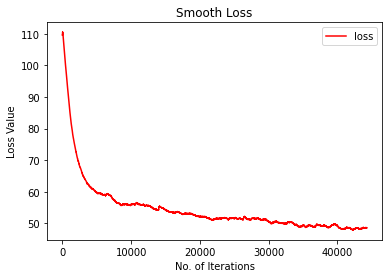

In [ ]:
#Smooth loss plot

jump = 10000

plt.figure()
plt.plot(smooth_loss_list, 'r', label='loss')
plt.title('Smooth Loss')
plt.xlabel('No. of Iterations')
plt.ylabel('Loss Value')
plt.xticks(np.arange(0, 45000, jump))
plt.legend()
plt.savefig('Smooth_Loss.png')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a01dcc76-30f1-4d9e-964c-6e3edcc6c5de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>